##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice Canned Estimator

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/canned_estimators"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/canned_estimators.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/lattice/tutorials/canned_estimators.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/lattice/tutorials/canned_estimators.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

준비된 estimator는 일반적인 사용 사례를 위해 TFL 모델을 훈련하는 빠르고 쉬운 방법입니다. 이 가이드에서는 TFL canned estimator를 만드는 데 필요한 단계를 설명합니다.

## 설정

TF Lattice 패키지 설치하기

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice

  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)


필수 패키지 가져오기

In [3]:
import tensorflow as tf

import copy
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)

UCI Statlog(Heart) 데이터세트 다운로드하기

In [4]:
csv_file = tf.keras.utils.get_file(
    'heart.csv', 'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)
target = df.pop('target')
train_size = int(len(df) * 0.8)
train_x = df[:train_size]
train_y = target[:train_size]
test_x = df[train_size:]
test_y = target[train_size:]
df.head()

16384/13273 [=====================================] - 0s 0us/step


24576/13273 [=======================================================] - 0s 0us/step


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  
0   0       fixed  
1   3      normal  
2   2  reversible  
3   0      normal  
4   0      normal

이 가이드에서 훈련에 사용되는 기본값 설정하기

In [5]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

## 특성 열

다른 TF estimator와 마찬가지로 데이터는 일반적으로 input_fn을 통해 estimator로 전달되어야 하며 [FeatureColumns](https://www.tensorflow.org/guide/feature_columns)를 사용하여 구문 분석됩니다.

In [6]:
# Feature columns.
# - age
# - sex
# - cp        chest pain type (4 values)
# - trestbps  resting blood pressure
# - chol      serum cholestoral in mg/dl
# - fbs       fasting blood sugar > 120 mg/dl
# - restecg   resting electrocardiographic results (values 0,1,2)
# - thalach   maximum heart rate achieved
# - exang     exercise induced angina
# - oldpeak   ST depression induced by exercise relative to rest
# - slope     the slope of the peak exercise ST segment
# - ca        number of major vessels (0-3) colored by flourosopy
# - thal      3 = normal; 6 = fixed defect; 7 = reversable defect
feature_columns = [
    fc.numeric_column('age', default_value=-1),
    fc.categorical_column_with_vocabulary_list('sex', [0, 1]),
    fc.numeric_column('cp'),
    fc.numeric_column('trestbps', default_value=-1),
    fc.numeric_column('chol'),
    fc.categorical_column_with_vocabulary_list('fbs', [0, 1]),
    fc.categorical_column_with_vocabulary_list('restecg', [0, 1, 2]),
    fc.numeric_column('thalach'),
    fc.categorical_column_with_vocabulary_list('exang', [0, 1]),
    fc.numeric_column('oldpeak'),
    fc.categorical_column_with_vocabulary_list('slope', [0, 1, 2]),
    fc.numeric_column('ca'),
    fc.categorical_column_with_vocabulary_list(
        'thal', ['normal', 'fixed', 'reversible']),
]

준비된 TFL estimator는 특성 열의 유형을 사용하여 사용할 보정 레이어 유형을 결정합니다. 숫자 특성 열에는 `tfl.layers.PWLCalibration`를, 범주형 특성 열에는 `tfl.layers.CategoricalCalibration` 레이어가 사용됩니다.

범주형 특성 열은 임베딩 특성 열로 래핑되지 않고 estimator에 직접 공급됩니다.

## input_fn 만들기

다른 estimator와 마찬가지로 input_fn을 사용하여 훈련 및 평가를 위해 모델에 데이터를 공급할 수 있습니다. TFL estimator는 특성의 분위수를 자동으로 계산하고 이를 PWL 보정 레이어의 입력 키포인트로 사용할 수 있습니다. 이를 위해서는 훈련 input_fn과 유사하지만 단일 epoch 또는 데이터의 하위 샘플이 있는 `feature_analysis_input_fn`를 전달해야 합니다.

In [7]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    num_threads=1)

# feature_analysis_input_fn is used to collect statistics about the input.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    # Note that we only need one pass over the data.
    num_epochs=1,
    num_threads=1)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=test_x,
    y=test_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

# Serving input fn is used to create saved models.
serving_input_fn = (
    tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec=fc.make_parse_example_spec(feature_columns)))

## 특성 구성

특성 보정 및 특성별 구성은 `tfl.configs.FeatureConfig`를 사용하여 설정됩니다. 특성 구성에는 단조 제약 조건, 특성별 정규화(`tfl.configs.RegularizerConfig` 참조) 및 격자 모델에 대한 격자 크기가 포함됩니다.

입력 특성에 대한 구성이 정의되지 않은 경우 `tfl.config.FeatureConfig`의 기본 구성이 사용됩니다.

In [8]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='age',
        lattice_size=3,
        # By default, input keypoints of pwl are quantiles of the feature.
        pwl_calibration_num_keypoints=5,
        monotonicity='increasing',
        pwl_calibration_clip_max=100,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='cp',
        pwl_calibration_num_keypoints=4,
        # Keypoints can be uniformly spaced.
        pwl_calibration_input_keypoints='uniform',
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='chol',
        # Explicit input keypoint initialization.
        pwl_calibration_input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
        monotonicity='increasing',
        # Calibration can be forced to span the full output range by clamping.
        pwl_calibration_clamp_min=True,
        pwl_calibration_clamp_max=True,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='fbs',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
    ),
    tfl.configs.FeatureConfig(
        name='trestbps',
        pwl_calibration_num_keypoints=5,
        monotonicity='decreasing',
    ),
    tfl.configs.FeatureConfig(
        name='thalach',
        pwl_calibration_num_keypoints=5,
        monotonicity='decreasing',
    ),
    tfl.configs.FeatureConfig(
        name='restecg',
        # Partial monotonicity: output(0) <= output(1), output(0) <= output(2)
        monotonicity=[(0, 1), (0, 2)],
    ),
    tfl.configs.FeatureConfig(
        name='exang',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
    ),
    tfl.configs.FeatureConfig(
        name='oldpeak',
        pwl_calibration_num_keypoints=5,
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='slope',
        # Partial monotonicity: output(0) <= output(1), output(1) <= output(2)
        monotonicity=[(0, 1), (1, 2)],
    ),
    tfl.configs.FeatureConfig(
        name='ca',
        pwl_calibration_num_keypoints=4,
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='thal',
        # Partial monotonicity:
        # output(normal) <= output(fixed)
        # output(normal) <= output(reversible)        
        monotonicity=[('normal', 'fixed'), ('normal', 'reversible')],
    ),
]

## 보정된 선형 모델

준비된 TFL estimator를 구성하려면 `tfl.configs`에서 모델 구성을 갖추세요. 보정된 선형 모델은 `tfl.configs.CalibratedLinearConfig`를 사용하여 구성됩니다. 입력 특성에 부분 선형 및 범주형 보정을 적용한 다음 선형 조합 및 선택적 출력 부분 선형 보정을 적용합니다. 출력 보정을 사용하거나 출력 경계가 지정된 경우 선형 레이어는 보정된 입력에 가중치 평균을 적용합니다.

이 예제에서는 처음 5개 특성에 대해 보정된 선형 모델을 만듭니다. `tfl.visualization`을 사용하여 보정 플롯으로 모델 그래프를 플롯합니다.

Calibrated linear test AUC: 0.834586501121521


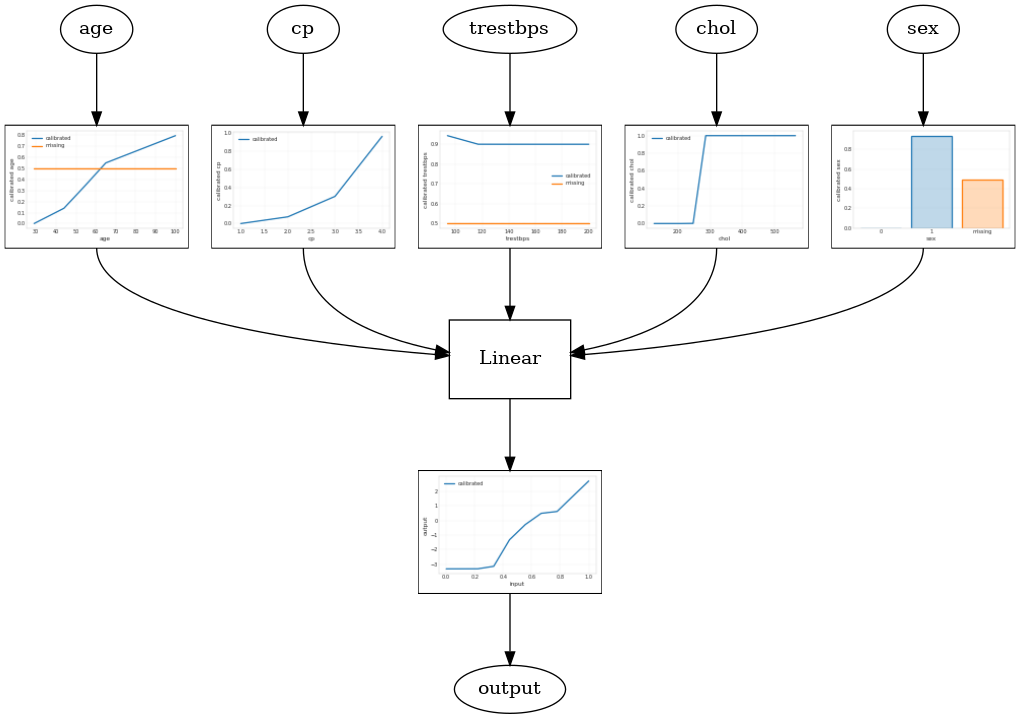

In [9]:
# Model config defines the model structure for the estimator.
model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    use_bias=True,
    output_calibration=True,
    regularizer_configs=[
        # Regularizer for the output calibrator.
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns[:5],
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Calibrated linear test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

## 보정된 격자 모델

보정된 격자 모델은 `tfl.configs.CalibratedLatticeConfig`를 사용하여 구성됩니다. 보정된 격자 모델은 입력 특성에 구간별 선형 및 범주형 보정을 적용한 다음 격자 모델 및 선택적 출력 구간별 선형 보정을 적용합니다.

이 예제에서는 처음 5개의 특성에 대해 보정된 격자 모델을 만듭니다.


Calibrated lattice test AUC: 0.8427318334579468


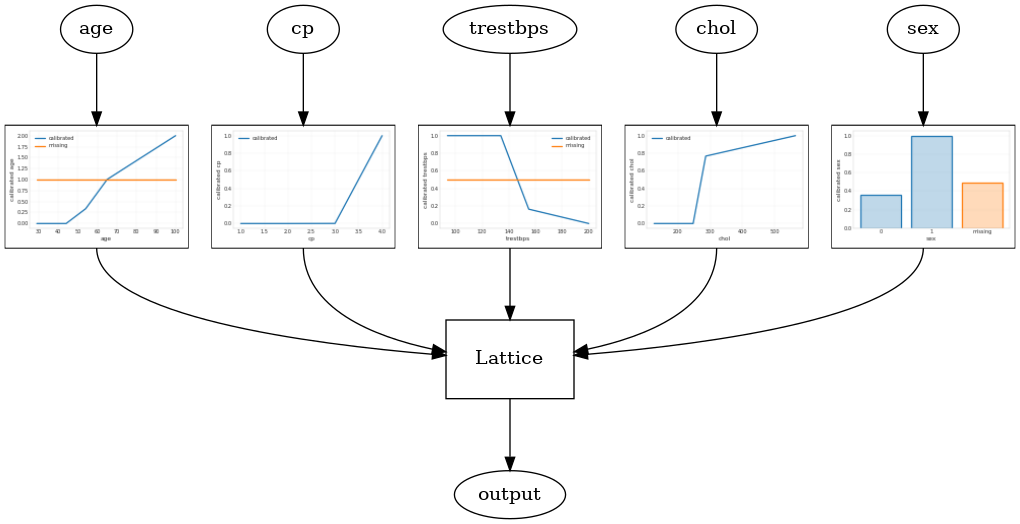

In [10]:
# This is calibrated lattice model: Inputs are calibrated, then combined
# non-linearly using a lattice layer.
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs,
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-4),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
    ])
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns[:5],
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Calibrated lattice test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

## 보정된 격자 앙상블

특성 수가 많으면 앙상블 모델을 사용할 수 있습니다. 이 모델은 특성의 하위 집합에 대해 여러 개의 작은 격자를 만들고, 하나의 거대한 격자를 만드는 대신 출력을 평균화합니다. 앙상블 격자 모델은 `tfl.configs.CalibratedLatticeEnsembleConfig`를 사용하여 구성됩니다. 보정된 격자 앙상블 모델은 입력 특성에 구간별 선형 및 범주형 보정을 적용한 다음 격자 모델 앙상블과 선택적 출력 구간별 선형 보정을 적용합니다.


### 무작위 격자 앙상블

다음 모델 구성은 각 격자에 대해 무작위의 특성 하위 집합을 사용합니다.

Random ensemble test AUC: 0.8984963297843933


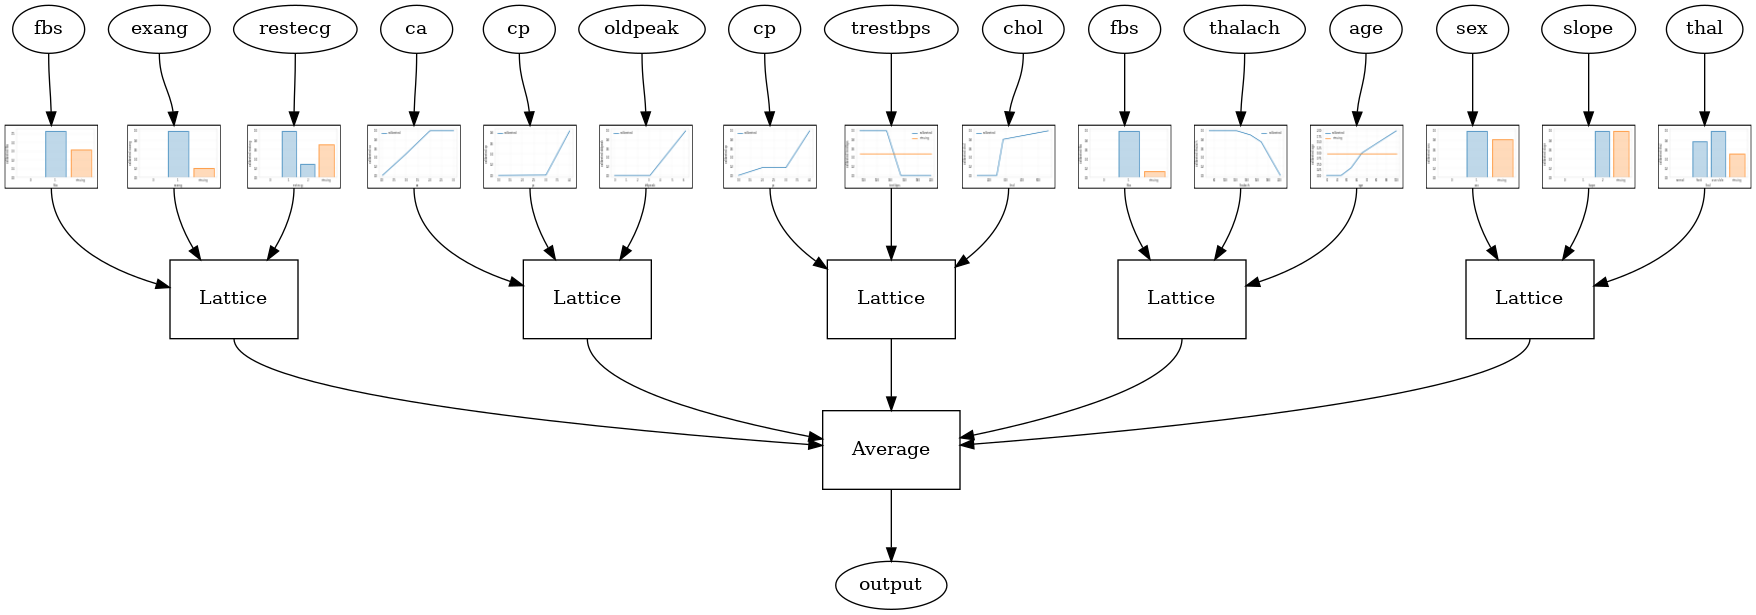

In [11]:
# This is random lattice ensemble model with separate calibration:
# model output is the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Random ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

### RTL 레이어 무작위 격자 앙상블

다음 모델 구성은 각 격자에 대해 무작위의 특성 하위 집합을 사용하는 `tfl.layers.RTL` 레이어를 사용합니다. `tfl.layers.RTL`은 단조 제약 조건만 지원하며 모든 특성에 대해 동일한 격자 크기를 가져야 하고 특성별 정규화가 없어야 합니다. `tfl.layers.RTL` 레이어를 사용하면 별도의 `tfl.layers.Lattice` 인스턴스를 사용하는 것보다 훨씬 더 큰 앙상블로 확장할 수 있습니다.

Random ensemble test AUC: 0.8903508186340332


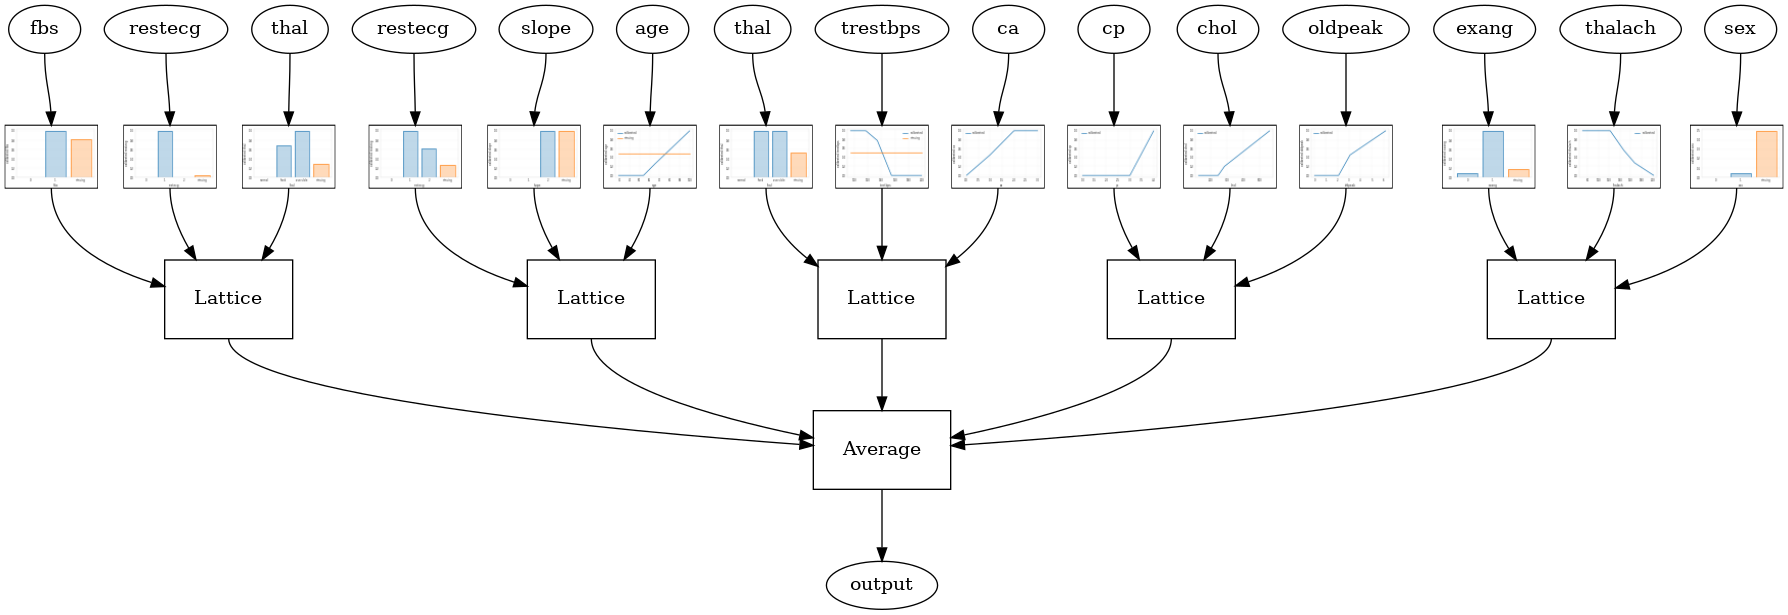

In [12]:
# Make sure our feature configs have the same lattice size, no per-feature
# regularization, and only monotonicity constraints.
rtl_layer_feature_configs = copy.deepcopy(feature_configs)
for feature_config in rtl_layer_feature_configs:
  feature_config.lattice_size = 2
  feature_config.unimodality = 'none'
  feature_config.reflects_trust_in = None
  feature_config.dominates = None
  feature_config.regularizer_configs = None
# This is RTL layer ensemble model with separate calibration:
# model output is the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    lattices='rtl_layer',
    feature_configs=rtl_layer_feature_configs,
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Random ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

### Crystals 격자 앙상블

TFL은 또한 [Crystals](https://papers.nips.cc/paper/6377-fast-and-flexible-monotonic-functions-with-ensembles-of-lattices)라고 하는 휴리스틱 특성 배열 알고리즘을 제공합니다. Crystals 알고리즘은 먼저 쌍별 특성 상호 작용을 예측하는 *사전 적합 모델*을 훈련합니다. 그런 다음 비 선형 상호 작용이 더 많은 특성이 동일한 격자에 있도록 최종 앙상블을 정렬합니다.

Crystals 모델의 경우 위에서 설명한 대로 사전 적합 모델을 훈련하는 데 사용되는 `prefitting_input_fn`도 제공해야 합니다. 사전 적합 모델은 완전하게 훈련될 필요가 없기에 몇 번의 epoch면 충분합니다.


In [13]:
prefitting_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=PREFITTING_NUM_EPOCHS,
    num_threads=1)

그런 다음 모델 구성에서 `lattice='crystals'` 를 설정하여 Crystal 모델을 만들 수 있습니다.

Crystals ensemble test AUC: 0.8859649300575256


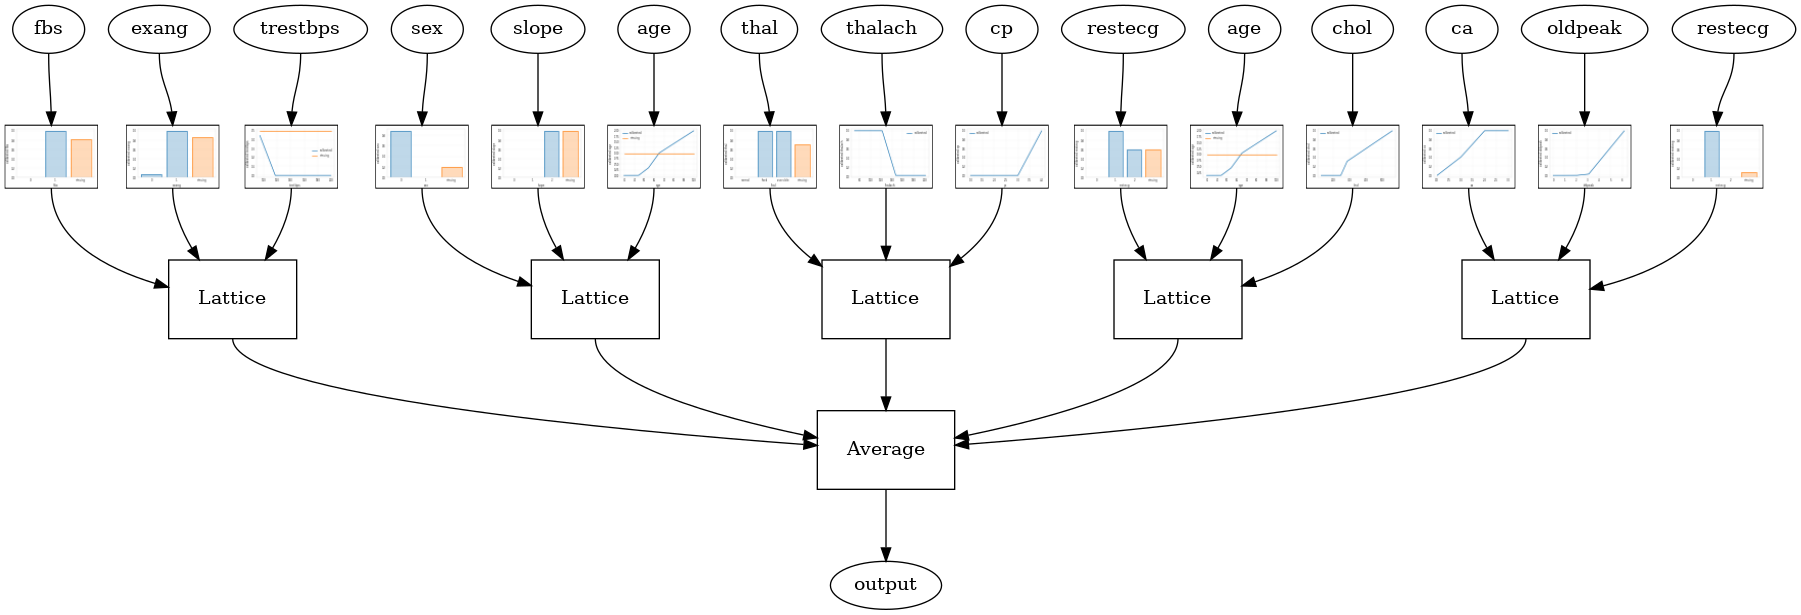

In [14]:
# This is Crystals ensemble model with separate calibration: model output is
# the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='crystals',
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    # prefitting_input_fn is required to train the prefitting model.
    prefitting_input_fn=prefitting_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    prefitting_optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Crystals ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

`tfl.visualization` 모듈을 사용하여 더 자세한 정보로 특성 calibrator를 플롯할 수 있습니다.

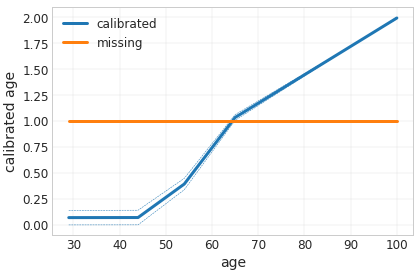

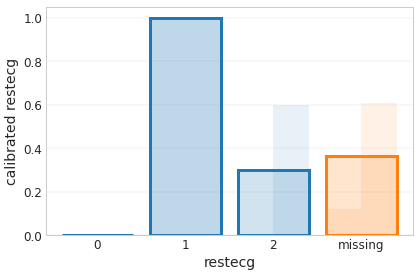

In [15]:
_ = tfl.visualization.plot_feature_calibrator(model_graph, "age")
_ = tfl.visualization.plot_feature_calibrator(model_graph, "restecg")